<a href="https://colab.research.google.com/github/nicolasrondan/cv-um-2021/blob/main/practico-3/Pra%CC%81ctico_3_Keypoints_Descriptores_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Montar Google Drive ####

In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/practico-3/

In [ ]:
! pip install -e ../cvum

# PRACTICO 3 - PUNTOS DE INTERES, DESCRIPTORES Y MATCHING

En este práctico vamos a estudiar distintos algoritmos para extraer puntos de interes (*keypoints*) y representarlos en descriptores. Además, se estudiará un caso simple de como hacer una correspondencia de puntos (*matching*) entre imágenes.

## Detector de Harris

En esta sección vamos a implementar una versión simple del detector de Harris, para ello vamos a utilizar un esqueleto de código como refrencia. El objetivo es cargar una imagen, aplicar el detector de Harris  e imprimir los puntos resultantes sobre la imagen original.
El procedimiento para aplicar el detector de Harris como vimos en clase es el siguiente: 


1.   Calcular el gradiente de la imagen en cada dirección
2.   Luego calculamos la matriz de Harris en cada punto y el score de Harris en cada punto.
3.   Umbralizar el score de Harris y definir cuales son detecciones válidas

Un resumen de estos pasos se puede encontrar en el la sección 4.1.1 del [libro Szeliski](https://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf).

En la siguiente imagen se hace un repaso de estos pasos. En este caso por simplicidad se pide implementar el algoritmo calculando el score de Harris en cada punto (pointwise) en vez de hacer una sumatoria sobre una ventana local.


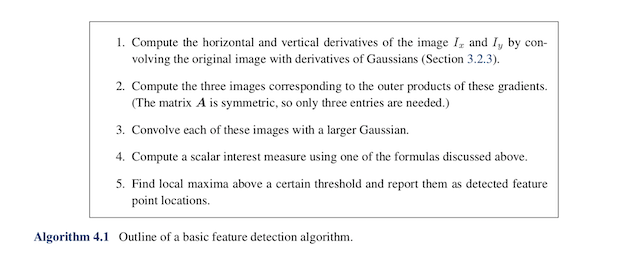

El resultado debería ser similar a la Figura:

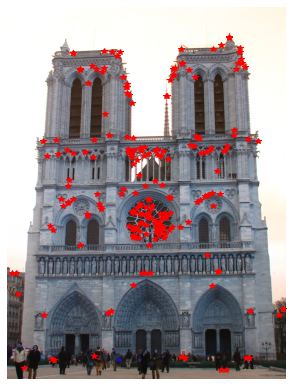


Se pueden comparar estos resultados a los obtenidos utilizando la función cv2.cornerHarris() de OpenCV.



**[Opcional]**     
El proceso de implementar la detección de Harris implica hacer un loop que itere por todos los puntos de una imagen para calcular la matriz de Harris y el score de Harris. Implementar una versión del algoritmo anterior que utilice operaciones de vectores. Las operaciones de vectores y matrices están optimizadas en Numpy (también en numpy, scipy y otros paquetes de Python), lo cual acelera el procesamiento de estás operaciones y evita los loops que pueden ser operaciones costosas.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
mpl.rc('figure', figsize=(20,10))

In [ ]:
## read input image
img_raw = cv2.imread('images/part1.jpg')
img_raw = cv2.resize(img_raw,(0,0), fx=0.5, fy=0.5)

## write a Harris detector
# compute the Ix,Iy,Iy

# grayscale the image
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

# apply gaussian filter to the image
img = cv2.GaussianBlur(img,(5,5),0.1)

#Ix= ....    #generate the Ix image 

#Iy= ....    #generate the Iy image
#IxIy=  .... #generate Ix*Iy image


sigma = 0.3

#apply gaussian filter for three new images
Ix= cv2.GaussianBlur(Ix,(5,5),sigma)
Iy= cv2.GaussianBlur(Iy,(5,5),sigma)
IxIy= cv2.GaussianBlur(Ixy,(5,5),sigma)

plt.figure(figsize=(20,8))
plt.imshow(np.concatenate([Ix,Iy,IxIy], axis=1), cmap='gray',vmax=650,vmin=-650)
plt.axis('off')
plt.title('Gradient Images Ix, Iy, IxIy')
plt.show()

#computer the Harris score for each points in the picture
alpha = 0.06 #according to the original paper

x,y = img.shape
harris_img = np.zeros([x,y])

for i in range(0,x):
    for j in range(0,y):
      #harris_matrix = np.array([[Ix[i,j]**2,Ix[i,j]*Iy[i,j]],[Ix[i,j]*Iy[i,j],(Iy[i,j])**2]]) #create the Harris matrix
      # use numpy functions to compute determinant and trace.
      #compute the Harris score using the formula provided in the course
      #save the Harris score in the harris_img matrix for plotting.


plt.figure(figsize=(5,8))
plt.imshow(harris_img, cmap='Blues')
plt.axis('off')
plt.title('Harris Score Image')
plt.show()
    
# Plot 
# set the threshold here

R = 0.01*harris_img.max()
coordinates = np.argwhere(harris_img > R)
ip_x = coordinates[:,0]
ip_y = coordinates[:,1]
plt.figure(figsize=(5,8))
plt.imshow(img_raw)
plt.axis('off')
plt.plot(ip_y,ip_x,'r*');




# **Correspondencia de Puntos**

En esta sección vamos a utilizar las funcion de OpenCV `cornerHarris()` para obtener puntos de interes en una imagen y realizar la correspondencia entre puntos de dos imágenes. Para ello vamos a utilizar un esqueleto de código con un flujo predefinido y para que funciones correctamente es necesario implementar varas funciones auxiliares. 

En la primera parte se lee una imagen y se le aplica una traslación para tener un mismo objeto pero en distintas posiciones en cada imagen. El objetivo de esta sección es: 

1. Implementar las funciones `extractDescrAppearance()` y `extractDescrGradient()` para extraer descriptores. 
2. Implementar la función `matchDescrs()` para detectar correspondencias entre los descriptores. 

Asumiendo que se detectaron N puntos de interes será necesario implemetar las siguientes funciones auxiliares:


### ***extractDescrAppearance()***:
Esta función toma como entrada un array de *N × 2* conteniendo las coordenadas de los puntos de interes y devuelve a la salida una matriz de tamaño *N* × *PatchSize* donde cada fila representa el vector de pixeles del parche centrado en cada punto de interes. Esta función se utilizara para describir un punto con un parche de "*apariencia*" de la image. Tambien es necesario controlar si todos los puntos son validos y devolver una lista de puntos válidos.

In [ ]:
def extractDescrAppearance(img,keypoints):
  ''' Extracts an appearance patch descriptor from keypoints.
      result = extractDescrAppearance(im,key_point) computes 3x3 image patch descriptors 
      centered at keypoints in image img.
      The result is a descriptor vector containing patch pixel values for
      each keypoint

      img : Gray image
      key_point : Key Point coordinates array.
  '''
  img_x, img_y  = img.shape
  num , _ = key_point.shape 

  valid_points = [] # create list of valid_points
  colour_h = [] # create list of descriptors
  
  return colour_h, valid_points

### ***extractDescrGradient()***:
Esta función toma como entrada un array de *N × 2* conteniendo las coordenadas de los puntos de interes y devuleve una matriz de tamaño *N×HistSize* representando el histograma de gradientes en cada parche alrededor de los puntos de interes. Se pueden utilizar la función [histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) de numpy. También se puede utilizar la función `calculate_image_gradient` incluida en el paquete cvum con utilidades para el curso.


In [ ]:
from cvum.utils import calculate_image_gradient

In [ ]:
def extractDescrGradient(img,keypoints):

  ''' Extracts a gradient based descriptor from keypoints.
      result = extractDescrGradient(im,key_point) computes gradients for each pixel in
      patch and builds a histogram based on gradient orientation. 
      centered at keypoints in image img.
      The result is a descriptor vector containing histogar of gradients for
      the patch arround each keypoint.
  '''
  num,_ = keypoints.shape
  img_x,img_y = img.shape
  hist_bins = np.arange(-180,181,30)
  valid_points= []
  gradient_hist_list = []


  
  #gradient_hist = ...
  return gradient_hist_list, valid_points


### ***matchDescrs()***
Esta función toma como entrada una matriz de descriptores para cada imagen y devuelve un vector de tamaño *N × 1* que define para cada punto de interes cual es el correspondiente en la segunda imagen. (Hint: investigar la función [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) de scipy aplicarla entre los descriptores y visualizarla en una imagen).


In [ ]:
def matchDescrs(descrs1, descrs2):
  ''' Computes de distances between two sets of descriptors and returns the
      closest match under a threshold. 
      result = matchDescrs(descrs1, descrs2) is a list of matches for each
      descriptor or -1 if no match is found.
  '''
  thres = 1 #min distance threshold
  matches_list = np.zeros(descrs1.shape[0])

  return matches_list

## Resultado Esperado

Una vez completadas las funciones se puede correr el código de la **Parte 2**. El resultado debería ser similar al de la siguiente Figura donde en la fila superior se visualiza la detección de puntos y en la siguiente el resultado de hacer las correspondencias.



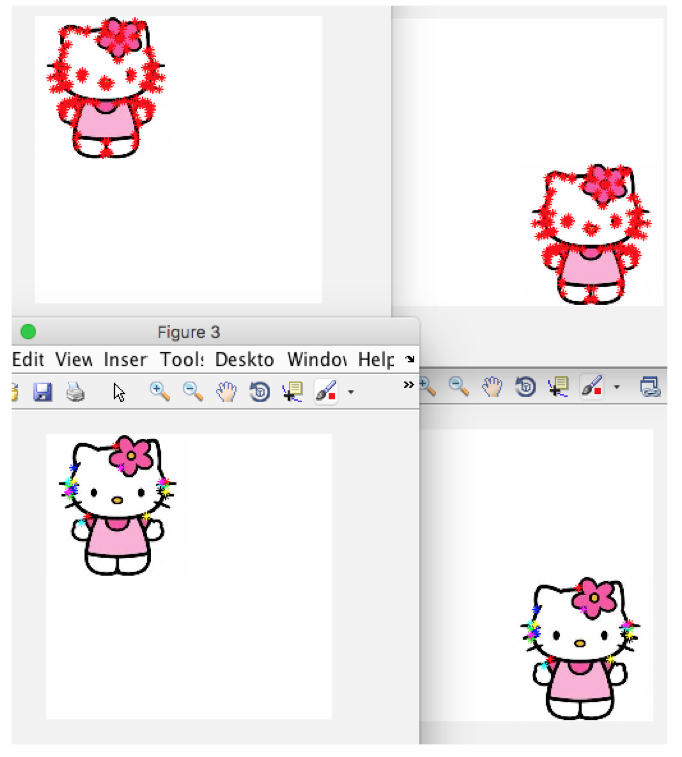

## 2. Visualización de Resultados



### 2.1 Cargar Imagen y Transformala

In [ ]:
## part 2 Interset Point Description & Matching
# Create two images by translating one image.

img_raw = cv2.imread('images/kittya.jpg')
img_raw = cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB)

#Generate white image same size as original
z = 255*np.ones(img_raw.shape, dtype=np.uint8)

#Concat white matrix with original image
img_raw1 = np.vstack([np.hstack([img_raw,z]),np.hstack([z,z])]) #original image on upper left corner
img_raw2 = np.vstack([np.hstack([z,z]),np.hstack([z,img_raw])]) #original image on bottom right corner

fig = plt.gcf()
fig.suptitle("Imagenes Originales", fontsize=14)
plt.subplot(121)
plt.imshow(img_raw1)
plt.subplot(122)
plt.imshow(img_raw2)
plt.show()


### 2.2 Calcular los keypoints para cada imagen

In [ ]:
# grayscale image 1
img1 = cv2.cvtColor(img_raw1, cv2.COLOR_BGR2GRAY)
#detect corners for image 1
keypoints1 = cv2.cornerHarris(img1,2,3,0.04)
# grayscale image 2
img2 = cv2.cvtColor(img_raw2, cv2.COLOR_BGR2GRAY)
# detect corners for image 2
keypoints2 = cv2.cornerHarris(img2,2,3,0.04)

# Transform the image with harris score into keypoint locations
keypoints_loc_1 = np.argwhere(keypoints1 > 0.1*keypoints1.max())
keypoints_loc_2 = np.argwhere(keypoints2 > 0.1*keypoints2.max())

fig = plt.gcf()
fig.suptitle("Imagenes Con Key Points", fontsize=14)
plt.subplot(121)
plt.imshow(img_raw1)
plt.plot(keypoints_loc_1[:,1],keypoints_loc_1[:,0], '*r')
plt.subplot(122)
plt.imshow(img_raw2)
plt.plot(keypoints_loc_2[:,1],keypoints_loc_2[:,0], '*r')
plt.show()

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
#extract appearance patch descriptor
colour_h1, valid_points = extractDescrAppearance(img1,keypoints_loc_1);
colour_h2, valid_points = extractDescrAppearance(img2,keypoints_loc_2);
colour_h1 = np.asarray(colour_h1)
colour_h2 = np.asarray(colour_h2)

# Since the image content is equal in both images the descriptors will be equal
print('Equal descriptors {}'.format(np.all(colour_h1==colour_h2)))
# Match descriptors
#Kill the first fraction of matches to sanity check.
colour_h2[0:30,:] = np.random.randn(30,colour_h2.shape[1])*10000
print('Equal descriptors {}'.format(np.all(colour_h1==colour_h2)))

In [ ]:
import seaborn as sns
## Use seaborn to visualize the distance between descriptors of keypoints in both images
## The diagonal should be black because every both set of descriptors are equal (both images have the same content at each point)
D = cdist(colour_h1,colour_h2)
sns.heatmap(D)
plt.show()

In [ ]:
# Match descriptors and draw matches with same colour
matchlist = matchDescrs(colour_h1,colour_h2)

In [ ]:
# Test Drawing with and without destroying h2 descriptors
clist='rgbcmykrgbcmykrgbcmyk'


fig = plt.gcf()
fig.suptitle("Matching de KeyPoints", fontsize=14)
_,axs = plt.subplots(1,2)
axs[0].imshow(img_raw1)
axs[1].imshow(img_raw2)
drawn_points = 0
points_limit = 21

for idx, element in enumerate(matchlist):
     if element > 0:
       axs[0].plot(keypoints_loc_1[idx,1], keypoints_loc_1[idx,0], clist[drawn_points]+'*')
       axs[1].plot(keypoints_loc_2[int(element),1], keypoints_loc_2[int(element),0], clist[drawn_points]+'*')
       drawn_points+=1
     if drawn_points == points_limit:
       break

plt.show()


### 2.3 Descriptor de Gradientes

In [ ]:
gradient_h1, valid_points_1 = extractDescrGradient(img1,keypoints_loc_1)
gradient_h2, valid_points_2 = extractDescrGradient(img2,keypoints_loc_2)
gradient_h1 = np.asarray(gradient_h1)
gradient_h2 = np.asarray(gradient_h2)

# Since the image content is equal in both images the descriptors will be equal
print('Equal descriptors {}'.format(np.all(gradient_h1==gradient_h2)))
# Match descriptors
#Kill the first fraction of matches to sanity check.
gradient_h2[0:30,:] = np.random.randn(30,gradient_h2.shape[1])*255
print('Equal descriptors {}'.format(np.all(gradient_h1==gradient_h2)))

In [ ]:
gradient_h2.shape

In [ ]:
matchlist_g = matchDescrs(gradient_h1,gradient_h2)

In [ ]:
clist='rgbcmykrgbcmykrgbcmyk'


fig = plt.gcf()
fig.suptitle("Matching de KeyPoints", fontsize=14)
_,axs = plt.subplots(1,2)
axs[0].imshow(img_raw1)
axs[1].imshow(img_raw2)
drawn_points = 0
points_limit = 21

for idx, element in enumerate(matchlist_g):
     if element > 0:
       axs[0].plot(keypoints_loc_1[idx,1], keypoints_loc_1[idx,0], clist[drawn_points]+'*')
       axs[1].plot(keypoints_loc_2[int(element),1], keypoints_loc_2[int(element),0], clist[drawn_points]+'*')
       drawn_points+=1
     if drawn_points == points_limit:
       break

plt.show()


#  Alineación de imágenes con RANSAC


En esta sección vamos a utilizar RANSAC para estimar de forma robusta la transformación afín entre dos imágenes. Para esta sección se provee un esqueleto de código que realiza los siguientes pasos:

1. Lee dos imágenes
2. Detecta puntos de interes (Utilizando el un detector de puntos de interes, vamos a utilizar BRISK que es un extractor de puntos incluido por defecto en OpenCV )
3. Describe los puntos utilizando la funcion `detectAndCompute()` que nos devuelve puntos de interes y su descriptor asociado
4. Hacer la correspondencia entre puntos usando un "*BruteForce*" matching. 
5. Calcula la transformación afín y hace la alineación de las imágenes utilizando mínimos cuadrados. 

Como vimos en clase esto no es suficientemente robusto. Por este motivo, se pide implementar un loop RANSAC que sea capaz de estimar la transformación afín  entre dos imágenes de manera robusta. Esta función debe devolver una matriz M de *3 × 2* que transforma cada punto X1 de la imagen 1 a sus correspondientes puntos X2 de la imagen 2, de manera que X2 = M * X1 genera la mayor cantidad de inliers en la transformación.

Recuerden que RANSAC toma un subset de puntos para cada iteración del loop y calcula la transformación que transforma los puntos X1 del subset en los puntos X2 del subset. Luego repite este procedimiento un número definido de veces hasta encontrar la transformación que genera más inliers en el set completo de puntos de interes.


Como último objetivo se pide generar un imagen panorama utilizando las dos imágenes alineadas.

### Cargar las Imágenes

In [ ]:
import os
image1 = 'images/part3_1.JPG'
image2 = 'images/part3_2.JPG'

In [ ]:
img1 = cv2.imread(image1,cv2.IMREAD_GRAYSCALE)         
img2 = cv2.imread(image2,cv2.IMREAD_GRAYSCALE) # trainImage
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(img1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2,cmap='gray')
plt.show()


### Detectar Puntos de Interes y Calcular sus Descriptores



In [ ]:
# Initiate ORB detector
detector = cv2.BRISK_create()
# find the keypoints and descriptors with ORB
kp1, des1 = detector.detectAndCompute(img1,None)
kp2, des2 = detector.detectAndCompute(img2,None)


### Hacer la correspondencia de Puntos

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

### Dibujar Matches

In [ ]:
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:30],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(img3)


### Estimar la transformación: Mínimos cuadrados


In [ ]:
# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)

for i, match in enumerate(good):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt


In [ ]:
### YOUR CODE TO ESTIMATE THE TRANSFORMATION
#transform_matrix = ...

In [ ]:
rows,cols = img1.shape

dst = cv2.warpAffine(img1,transform_matrix.T,(cols,rows))

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2,cmap='gray')
plt.axis('off')
plt.show()

#### Visualizar el Resultado

In [ ]:
mask = ~(dst > 0)
masked = cv2.bitwise_and(img2, img2, mask=mask.astype(np.uint8))
stitch = dst + masked

In [ ]:
plt.imshow(stitch, cmap='gray')

### Minimos cuadrados con ruido

El ejemplo anterior funcionó bastante bien, ahora hagamos el intento agregando ruido a los puntos.

In [ ]:
noise1 = np.random.uniform(0,683,1000);
noise2 = np.random.uniform(0,1024,1000);

k = 5;
noise1 = np.random.choice(noise1, k);
noise2 = np.random.choice(noise2, k);
noise = np.vstack([noise1,noise2]).T;

num,_ = points1.shape;

index_rand = np.random.choice(range(0,num),k*8);
points1 = points1[index_rand,:];
points2 = points2[index_rand,:];

points1 = np.vstack([points1,noise]);
points2 = np.vstack([points2,noise]);

In [ ]:
#Minimos cuadrados nuevamente
### YOUR CODE TO ESTIMATE THE TRANSFORMATION
#transform_matrix = ...

In [ ]:
rows,cols = img1.shape
dst = cv2.warpAffine(img1,transform_matrix.T,(cols,rows))

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2,cmap='gray')
plt.axis('off')

#### Visualizar el Resultado

In [ ]:
mask = ~(dst > 0)
masked = cv2.bitwise_and(img2, img2, mask=mask.astype(np.uint8))
stitch = dst + masked
plt.imshow(stitch, cmap='gray')

### *RANSAC*

En la funcion `ransac_loop_affine` se pide calcular la transformación afín utilizando un loop ransac sobre los puntos con ruido.

In [ ]:
def ransac_loop_affine(points1,points2, iterations,k=6, threshold_distance=0.05):
    transform_matrix=[]
    return transform_matrix

In [ ]:
transform_matrix = ransac_loop_affine(points1,points2,1500,k=6, threshold_distance=1) #Img1 points, Img2 points, Number of RANSAC iterations.
rows,cols = img1.shape
dst = cv2.warpAffine(img1,transform_matrix.T,(cols,rows))

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2,cmap='gray')
plt.axis('off')
plt.show()

#### Visualizar el Resultado

In [ ]:
mask = ~(dst > 0)
masked = cv2.bitwise_and(img2, img2, mask=mask.astype(np.uint8))
stitch = dst + masked
plt.imshow(stitch, cmap='gray')
plt.show()

# [OPCIONAL] Escribir código para hacer panorama stitching hint: [link text](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html)